In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate, Masking, LSTM, TimeDistributed, Lambda, Reshape, Multiply, BatchNormalization, Bidirectional
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
import h5py 
import os 
from clr_callback import *
from tensorflow.keras.callbacks import TensorBoard
import tensorflow.keras.backend as K  
from tensorflow.keras.optimizers import * 
# import keras_one_cycle_clr as ktool

os.environ["CUDA_VISIBLE_DEVICES"]="0"

%matplotlib inline 

dataset = h5py.File('./../../../../../data/hongtao/both-15-1-2021.h5','r')
# ['j1_pt', 'j1_eta', 'j1_phi', 'j1_x', 'j1_y', 'j1_z', 'j1_m', 'j1_e', 'j1_isbtag', 'j1_isbtag', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_x', 'j2_y', 'j2_z', 'j2_m', 'j2_e', 'j2_isbtag', 'j2_isbtag', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_x', 'j3_y', 'j3_z', 'j3_m', 'j3_e', 'j3_isbtag', 'j3_isbtag', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_x', 'j4_y', 'j4_z', 'j4_m', 'j4_e', 'j4_isbtag', 'j4_isbtag', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_x', 'j5_y', 'j5_z', 'j5_m', 'j5_e', 'j5_isbtag', 'j5_isbtag', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_x', 'j6_y', 'j6_z', 'j6_m', 'j6_e', 'j6_isbtag', 'j6_isbtag', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_x', 'lep_y', 'lep_z', 'lep_e', 'met_met', 'met_phi']

X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_isbtag', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_isbtag', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_isbtag', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_isbtag', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_isbtag', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_isbtag', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']

Y_keys = ['th_pt', 'th_eta','th_phi','th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m']
phi_keys = list(filter(lambda a: 'phi' in a, dataset.keys()))
eta_keys = list(filter(lambda a: 'eta' in a, dataset.keys()))
pt_keys =  list(filter(lambda a: 'pt' in a, dataset.keys()))
m_keys = list(filter(lambda a: 'm' in a, dataset.keys()))
isbtag_keys = list(filter(lambda a: 'isbtag' in a, dataset.keys()))

Y_length = len(Y_keys)
X_length = len(X_keys)
crop0 =  15712180

In [2]:
X_maxmean = np.load('saved/X_maxmean1.npy')
Y_maxmean = np.load('saved/Y_maxmean1.npy')

print(np.array(dataset.get('j1_isbtag')).size)

15712180


In [3]:
import normalize
import shape_timesteps

Scaler = normalize.Scale_variables()
X_total, X_names = Scaler.scale_arrays(X_keys, X_maxmean)
Y_total, Y_names = Scaler.scale_arrays(Y_keys, Y_maxmean)

error = Scaler.test_inverse(Y_keys, Y_maxmean)
print('')
print(error)


[2.27373675e-13 8.88178420e-16 1.23668630e-07 0.00000000e+00
 1.13686838e-13 1.77635684e-15 1.24941187e-07 0.00000000e+00
 2.27373675e-13 8.88178420e-16 1.23004660e-07 0.00000000e+00
 2.27373675e-13 8.88178420e-16 1.24443029e-07 0.00000000e+00]


In [4]:
# Create X and test array
split = int(np.floor(0.95*crop0)) # 80/20 split 

trainY, testY = Y_total[0:split,:], Y_total[split:,:]

timestep_builder = shape_timesteps.Shape_timesteps()
totalX_jets, totalX_other = timestep_builder.reshape_X(X_total, X_names, False,True)
    
    


In [5]:
trainX_jets, testX_jets = totalX_jets[0:split,:,:], totalX_jets[split:,:,:]
trainX_other, testX_other = totalX_other[0:split,:], totalX_other[split:,:]

print(trainX_jets.shape, trainX_other.shape, trainY.shape)
print(testX_jets.shape, testX_other.shape, testY.shape)

(14926571, 6, 6) (14926571, 7) (14926571, 20)
(785609, 6, 6) (785609, 7) (785609, 20)


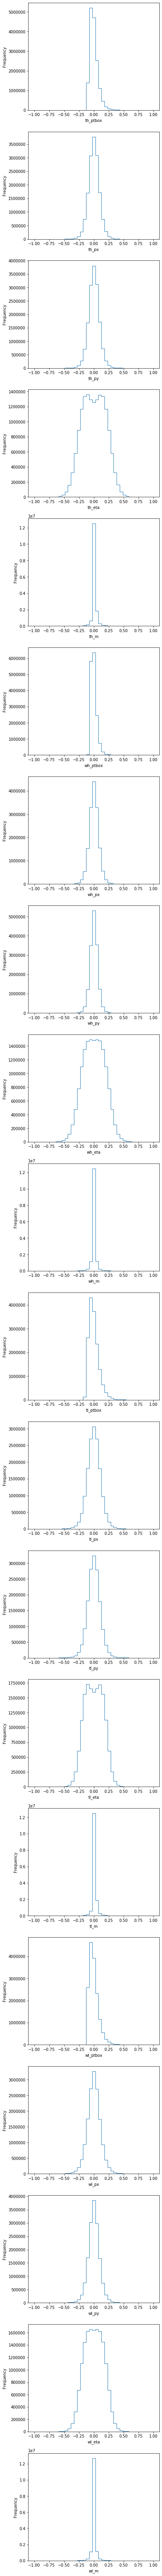

In [6]:
# Histograms of total  Y variables 
show = True

other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-1, 1, 40)
pt_bins = np.linspace(-1, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        bins = Y_bins[i]
        plt.hist(Y_total[:,i], bins, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')


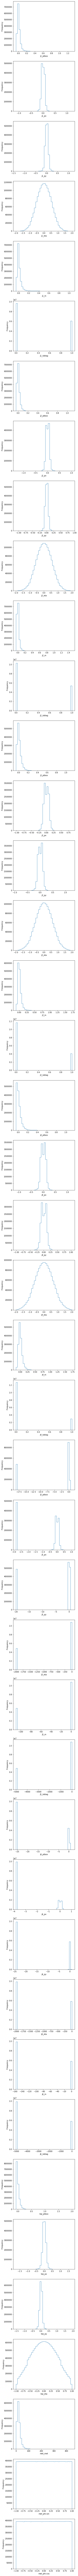

In [7]:
# Histograms of X variables (without the mask)
show = True

if show:
    plt.figure(figsize=(6,6*X_total.shape[1]))
    for i in range(0, X_total.shape[1]):
        plt.subplot(X_total.shape[1], 1, i+1)
        plt.hist(X_total[:,i], 40, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

 

In [8]:
def build_model():
    jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))
    Mask = Masking(-2)(jet_input)
    Maskshape = Reshape((trainX_jets.shape[1], trainX_jets.shape[2]))(Mask)
    other_input = Input(shape=(trainX_other.shape[1]))
    flat_jets =  Flatten()(jet_input)
    concat0 = concatenate([other_input, flat_jets])
    PreDense1 = Dense(256, activation='relu')(concat0)
    PreDense2 = Dense(256, activation='relu')(PreDense1)
    PreDense3 = Dense(trainX_jets.shape[1], activation='sigmoid')(PreDense2)
    Shape_Dot = Reshape((-1,1))(PreDense3)
    
    TDDense11 = TimeDistributed(Dense(128, activation='relu'))(Maskshape)
    TDDense12 = TimeDistributed(Dense(64, activation='relu'))(TDDense11)
    Dot_jets = Multiply()([Shape_Dot, TDDense12])
    TDDense13 = TimeDistributed(Dense(128, activation='relu'))(Dot_jets)
    TDDense14= TimeDistributed(Dense(128, activation='relu'))(TDDense13)
    flat_right = Flatten()(TDDense14)
    
    Dense21 = Dense(128, activation='relu')(other_input)
    Dense22 = Dense(128, activation='relu')(Dense21)
    flat_other = Flatten()(Dense22)
    
    concat = concatenate([flat_other, flat_right])
    
    ldense1 = Dense(256, activation='relu')(concat)
    ldense2 = Dense(128, activation='relu')(ldense1)
    loutput = Dense(len(Y_names)//2)(ldense2)
    
    hconcat = concatenate([loutput, concat])
    hdense1 = Dense(256, activation='relu')(hconcat)
    hdense2 = Dense(128, activation='relu')(hdense1)
    houtput = Dense(len(Y_names)//2)(hdense2)
    
    output = concatenate([houtput, loutput])
    
    model = keras.models.Model(inputs=[jet_input, other_input], outputs=output)
    
    def loss_fc(true, pred):
        return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))
    # lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=5000,decay_rate=0.6)
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=1e-3, decay_steps=10000,end_learning_rate=5e-5,power=0.25)
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='mae', optimizer= optimizer, metrics=['mse'])
    
    return model 

def loss_fc(true, pred):
        return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))
    
model = keras.models.load_model('12-3-clean.keras', custom_objects={'loss_fc':loss_fc})
# model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 6)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 36)           0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 43)           0           input_2[0][0]                    
                                                                 flatten[0][0]                

In [9]:
# Fit model

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
clr_triangular = CyclicLR(base_lr=1e-5, max_lr=1e-4, step_size=5000, mode='exp_range',gamma=0.9999)
# class_weight = {0:2, 1:1, 2:1, 3:1, 4:1, 5:2, 6:1, 7:1, 8:1, 9:1, 10:2, 11:1, 12:1, 13:1, 14:1, 15:2, 16:1, 17:1, 18:1, 19:1}


Epochs= 256

# del X_total
# del Y_total
# def loss(true, pred):
#     return K.mean(K.square(true-pred)*(1+K.square(true)))



history = model.fit([trainX_jets, trainX_other], trainY, verbose=1, epochs=Epochs,
                   validation_data=([testX_jets, testX_other], testY), shuffle=True, callbacks=[early_stop],
                    batch_size=1000)

Epoch 1/256
14927/14927 [==============================] - 85s 6ms/step - loss: 0.0296 - mean_squared_error: 0.0024 - val_loss: 0.0291 - val_mean_squared_error: 0.0024
Epoch 2/256
14927/14927 [==============================] - 85s 6ms/step - loss: 0.0290 - mean_squared_error: 0.0024 - val_loss: 0.0289 - val_mean_squared_error: 0.0024
Epoch 3/256
14927/14927 [==============================] - 85s 6ms/step - loss: 0.0288 - mean_squared_error: 0.0024 - val_loss: 0.0288 - val_mean_squared_error: 0.0024
Epoch 4/256
14927/14927 [==============================] - 85s 6ms/step - loss: 0.0287 - mean_squared_error: 0.0023 - val_loss: 0.0287 - val_mean_squared_error: 0.0024
Epoch 5/256
14927/14927 [==============================] - 85s 6ms/step - loss: 0.0286 - mean_squared_error: 0.0023 - val_loss: 0.0286 - val_mean_squared_error: 0.0023
Epoch 6/256
14927/14927 [==============================] - 86s 6ms/step - loss: 0.0285 - mean_squared_error: 0.0023 - val_loss: 0.0286 - val_mean_squared_error:

14927/14927 [==============================] - 87s 6ms/step - loss: 0.0275 - mean_squared_error: 0.0022 - val_loss: 0.0277 - val_mean_squared_error: 0.0023
Epoch 98/256
14927/14927 [==============================] - 87s 6ms/step - loss: 0.0275 - mean_squared_error: 0.0022 - val_loss: 0.0277 - val_mean_squared_error: 0.0023
Epoch 99/256
14927/14927 [==============================] - 87s 6ms/step - loss: 0.0275 - mean_squared_error: 0.0022 - val_loss: 0.0277 - val_mean_squared_error: 0.0023
Epoch 100/256
14927/14927 [==============================] - 88s 6ms/step - loss: 0.0275 - mean_squared_error: 0.0022 - val_loss: 0.0277 - val_mean_squared_error: 0.0023
Epoch 101/256
14927/14927 [==============================] - 86s 6ms/step - loss: 0.0275 - mean_squared_error: 0.0022 - val_loss: 0.0277 - val_mean_squared_error: 0.0023
Epoch 102/256
14927/14927 [==============================] - 87s 6ms/step - loss: 0.0275 - mean_squared_error: 0.0022 - val_loss: 0.0277 - val_mean_squared_error: 0.0

In [10]:
# plt.xlabel('Training Iterations')
# plt.ylabel('Learning Rate')
# plt.title("CLR - 'triangular' Policy")
# plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

Text(0.5, 1.0, 'MSE loss')

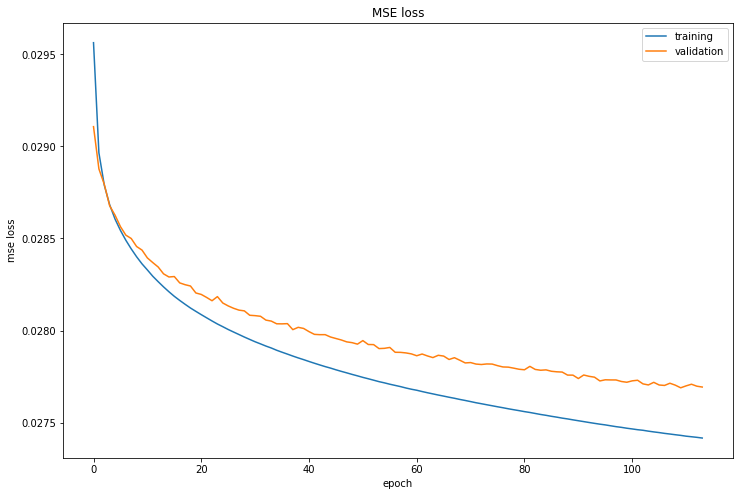

In [11]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [12]:
predictions_unscaled = model.predict([testX_jets, testX_other])
true_unscaled = testY 

total_predictions = model.predict([np.append(trainX_jets,testX_jets,axis=0), np.append(trainX_other,testX_other,axis=0)])
Y_total, _ = Scaler.scale_arrays(Y_keys, Y_maxmean)

predictions_origscale = Scaler.invscale_arrays(total_predictions, Y_names, Y_maxmean)[split:,:]
true_origscale = Scaler.invscale_arrays(Y_total, Y_names, Y_maxmean)[split:,:]

In [13]:
from tensorflow.keras.models import Model

layer_name = 'dense_2'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict([testX_jets, testX_other])

[0.69281167 0.4798653  0.68799394 0.56246585 0.19693254 0.5413264 ]


(array([4.00000e+00, 6.00000e+00, 2.10000e+01, 4.30000e+01, 9.60000e+01,
        2.30000e+02, 4.33000e+02, 8.00000e+02, 1.62200e+03, 2.96300e+03,
        5.49600e+03, 9.96700e+03, 1.82270e+04, 3.25220e+04, 5.48830e+04,
        8.44590e+04, 1.15927e+05, 1.30950e+05, 1.20615e+05, 9.23230e+04,
        5.91030e+04, 3.17420e+04, 1.46030e+04, 5.62000e+03, 1.98400e+03,
        6.55000e+02, 2.33000e+02, 6.20000e+01, 1.50000e+01, 5.00000e+00]),
 array([0.3257908 , 0.34005606, 0.35432136, 0.36858663, 0.3828519 ,
        0.3971172 , 0.41138247, 0.42564774, 0.439913  , 0.4541783 ,
        0.46844357, 0.48270884, 0.49697414, 0.5112394 , 0.5255047 ,
        0.53976995, 0.55403525, 0.56830055, 0.5825658 , 0.5968311 ,
        0.6110964 , 0.6253616 , 0.6396269 , 0.65389216, 0.66815746,
        0.68242276, 0.696688  , 0.7109533 , 0.7252186 , 0.73948383,
        0.75374913], dtype=float32),
 <a list of 30 Patch objects>)

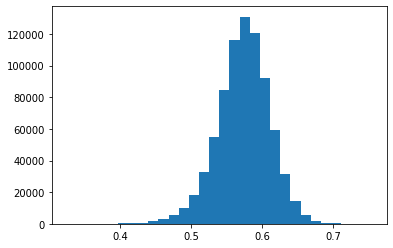

In [14]:
print(intermediate_output[0,:])
plt.hist(intermediate_output[:,5], 30)

In [15]:
# np.save('saved/7-9-2020-jetreweight-mae', predictions_origscale)
# np.save('saved/7-9-2020-jetreweight-mae-true', true_origscale)

In [16]:
print(predictions_origscale.shape, true_origscale.shape)

(785609, 16) (785609, 16)


# Training scale plots 

In [17]:
import analysis

Analysis = analysis.Analysis 
Analysis.display_errors(predictions_unscaled, true_unscaled, Y_names, False)

total MSE: 0.0022775310465438198
 
th_ptbox MSE, MAE :  0.0011252888 0.0238020025
th_px MSE, MAE :  0.0021878335 0.0298476199
th_py MSE, MAE :  0.0021296314 0.0295484704
th_eta MSE, MAE :  0.0075320143 0.0490714354
th_m MSE, MAE :  0.0011918901 0.0177548607
wh_ptbox MSE, MAE :  0.0011354362 0.0231228395
wh_px MSE, MAE :  0.0024809680 0.0335176057
wh_py MSE, MAE :  0.0016523180 0.0274837706
wh_eta MSE, MAE :  0.0081001239 0.0542522978
wh_m MSE, MAE :  0.0015681246 0.0204982399
tl_ptbox MSE, MAE :  0.0012153263 0.0245649707
tl_px MSE, MAE :  0.0016674492 0.0270346228
tl_py MSE, MAE :  0.0014898234 0.0255899245
tl_eta MSE, MAE :  0.0038509596 0.0398310456
tl_m MSE, MAE :  0.0012046378 0.0178512380
wl_ptbox MSE, MAE :  0.0005956865 0.0171882390
wl_px MSE, MAE :  0.0005787887 0.0171567781
wl_py MSE, MAE :  0.0004140333 0.0145562847
wl_eta MSE, MAE :  0.0040403408 0.0418471250
wl_m MSE, MAE :  0.0013899468 0.0193483054


In [18]:
Analysis.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 286.0295874242547
 
th_pt MSE, MAE :  1504.2224962221 27.5193102443
th_eta MSE, MAE :  0.6257875415 0.4472873856
th_phi MSE, MAE :  0.7794516643 0.5150195955
th_m MSE, MAE :  10.0264942210 1.6284473547
wh_pt MSE, MAE :  1638.6101016251 27.7777849620
wh_eta MSE, MAE :  0.6451860508 0.4841888585
wh_phi MSE, MAE :  0.9376757582 0.6119578542
wh_m MSE, MAE :  18.4487433398 2.2233594801
tl_pt MSE, MAE :  1020.4766918268 22.5097849412
tl_eta MSE, MAE :  0.4418626058 0.4266589413
tl_phi MSE, MAE :  0.4878186881 0.3772306910
tl_m MSE, MAE :  10.1326159442 1.6371968098
wl_pt MSE, MAE :  345.7314600639 13.0945914866
wl_eta MSE, MAE :  0.3349221189 0.3810031306
wl_phi MSE, MAE :  0.1404326021 0.1990402304
wl_m MSE, MAE :  18.3931532163 2.2257272181


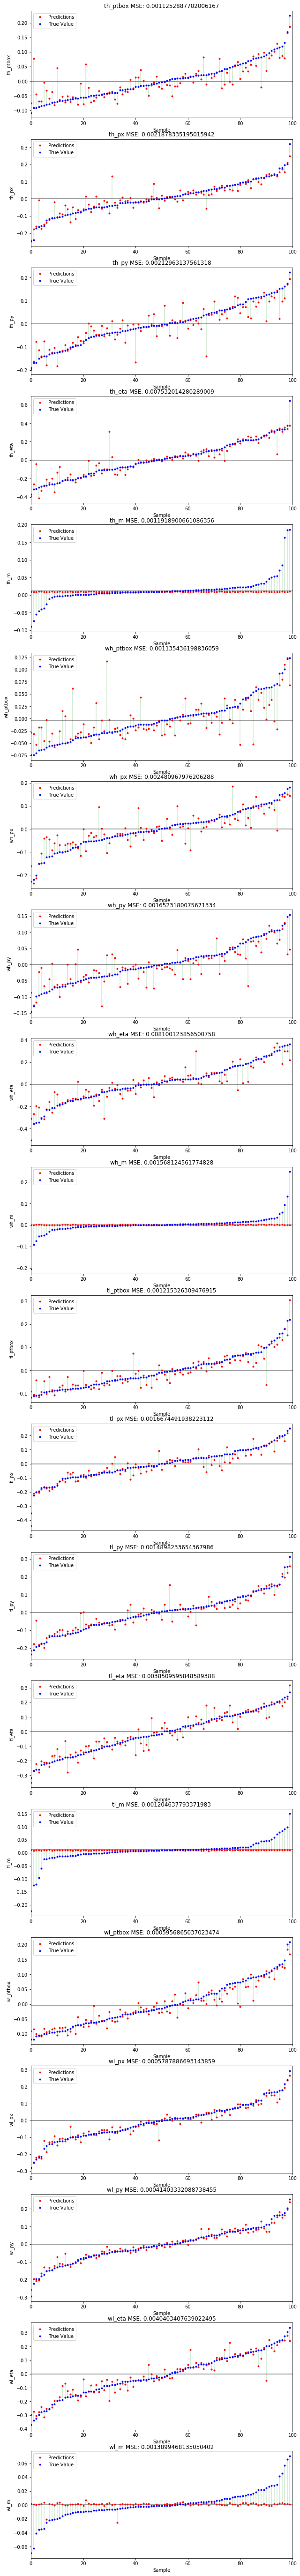

In [19]:
Analysis.predictions_vs_sample(predictions_unscaled, true_unscaled, Y_names, False)

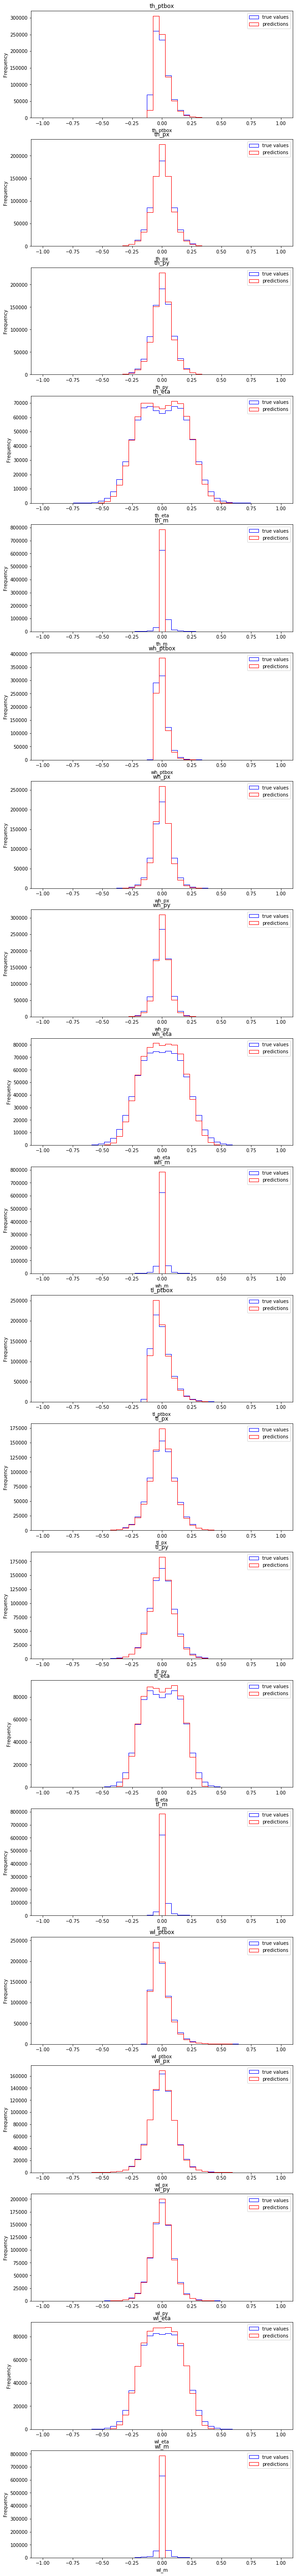

In [20]:
Analysis.variable_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

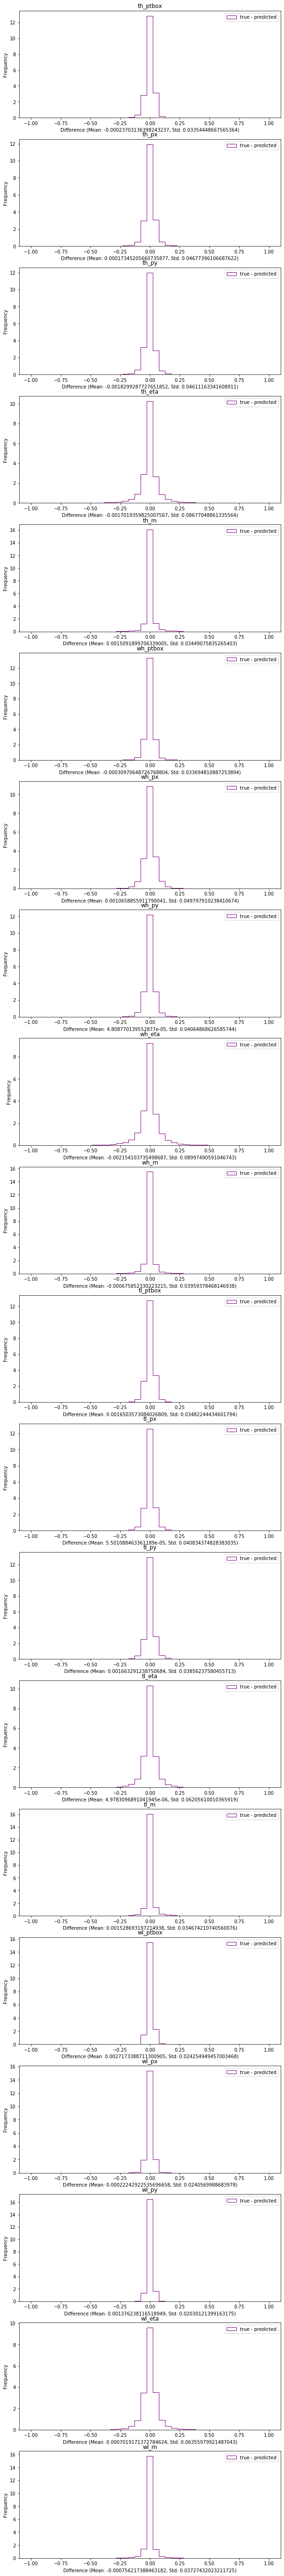

In [21]:
Analysis.difference_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

In [22]:
# Analysis.predicted_vs_true(predictions_unscaled, true_unscaled, Y_names, False)

 # Original scale plots

In [23]:
Analysis.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 286.0295874242547
 
th_pt MSE, MAE :  1504.2224962221 27.5193102443
th_eta MSE, MAE :  0.6257875415 0.4472873856
th_phi MSE, MAE :  0.7794516643 0.5150195955
th_m MSE, MAE :  10.0264942210 1.6284473547
wh_pt MSE, MAE :  1638.6101016251 27.7777849620
wh_eta MSE, MAE :  0.6451860508 0.4841888585
wh_phi MSE, MAE :  0.9376757582 0.6119578542
wh_m MSE, MAE :  18.4487433398 2.2233594801
tl_pt MSE, MAE :  1020.4766918268 22.5097849412
tl_eta MSE, MAE :  0.4418626058 0.4266589413
tl_phi MSE, MAE :  0.4878186881 0.3772306910
tl_m MSE, MAE :  10.1326159442 1.6371968098
wl_pt MSE, MAE :  345.7314600639 13.0945914866
wl_eta MSE, MAE :  0.3349221189 0.3810031306
wl_phi MSE, MAE :  0.1404326021 0.1990402304
wl_m MSE, MAE :  18.3931532163 2.2257272181


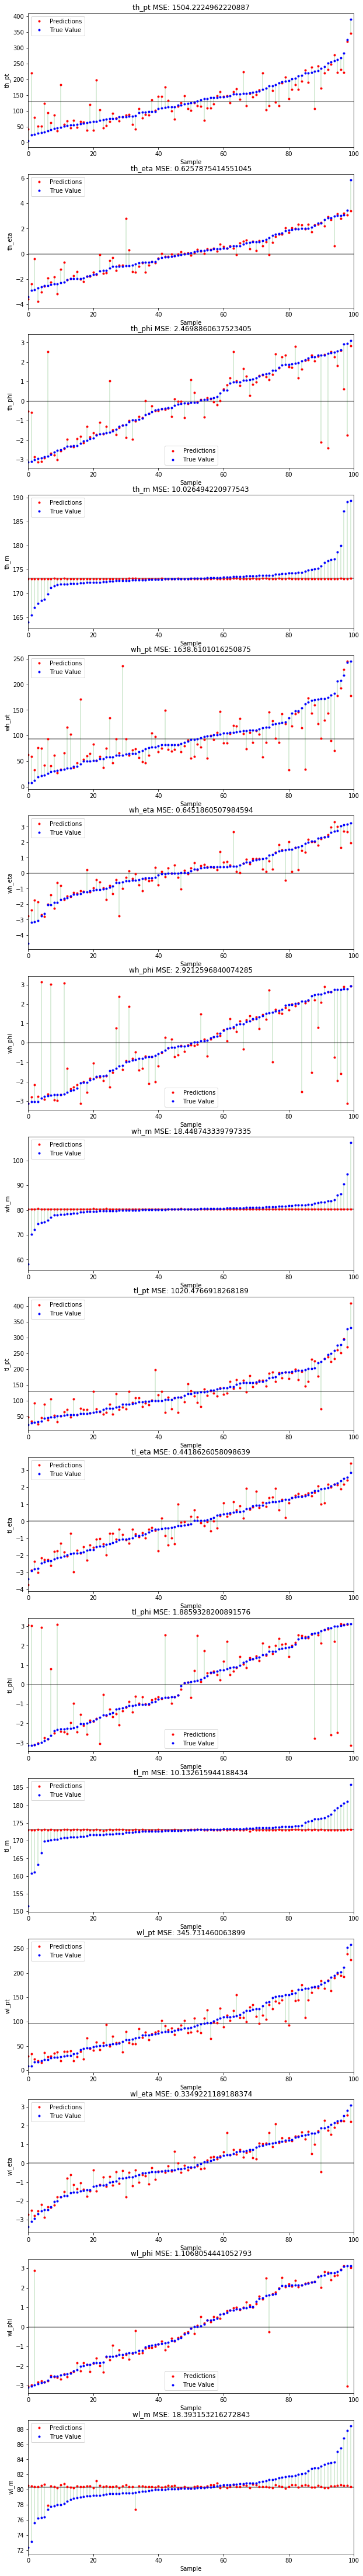

In [24]:
Analysis.predictions_vs_sample(predictions_origscale, true_origscale, Y_keys, True)

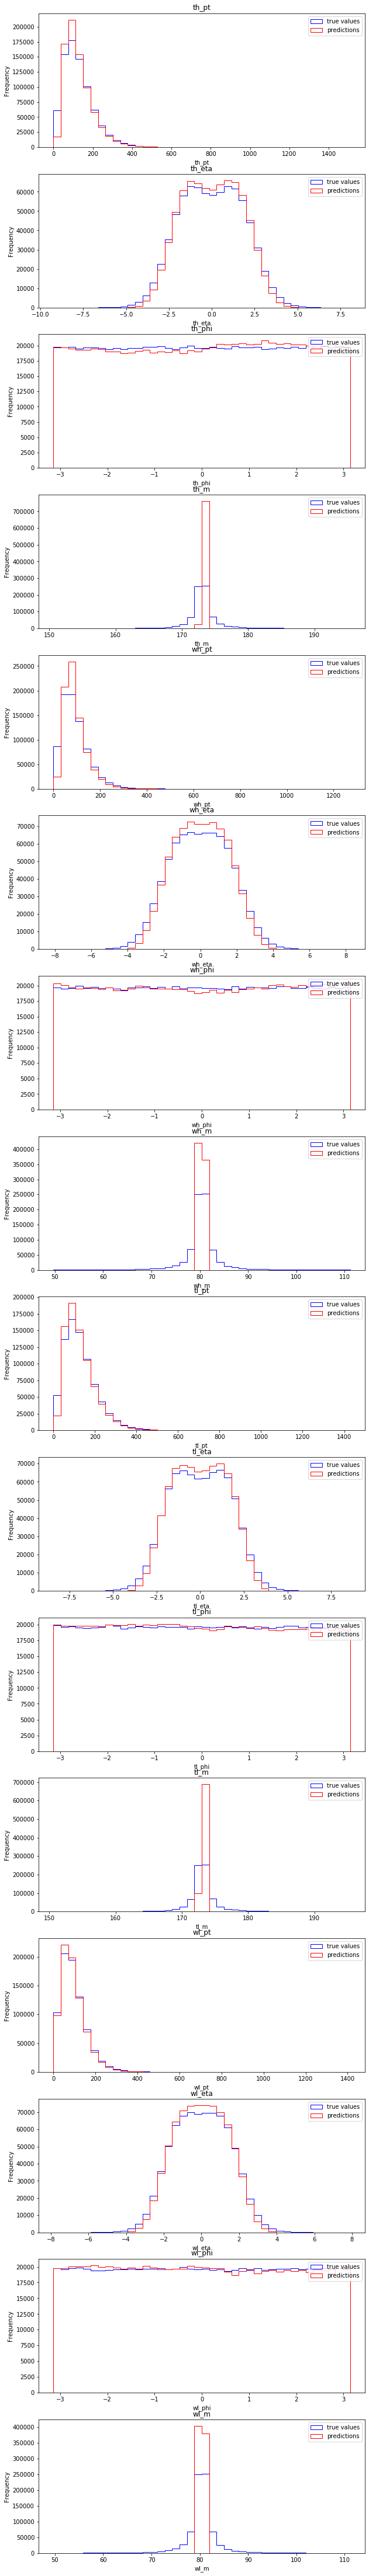

In [25]:
Analysis.variable_histogram(predictions_origscale, true_origscale, Y_keys, True, [None for name in Y_names])

In [26]:
# Analysis.predicted_vs_true(predictions_origscale, true_origscale, Y_keys, True)

In [27]:
model.save('31-7-dl1r.keras')

# Observables

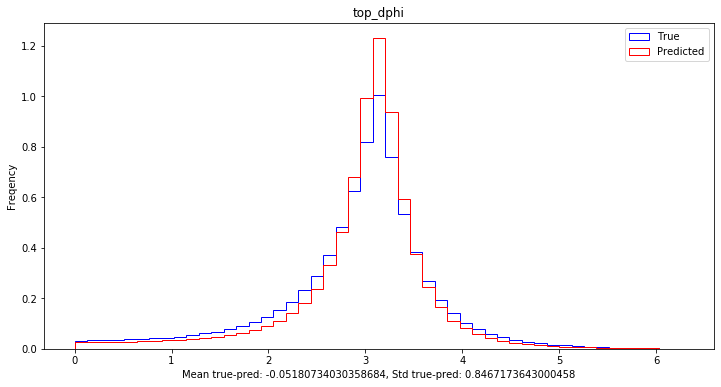

In [28]:
import observables 
import importlib
importlib.reload(observables)
truths = observables.fill_observables(true_origscale, True, Y_keys)
preds = observables.fill_observables(predictions_origscale, False, Y_keys)

# top_dphi=np.abs(th_phi-tl_phi)
plt.figure(figsize=(12,6))
observables.plot_hist(truths['top_dphi'], preds['top_dphi'])

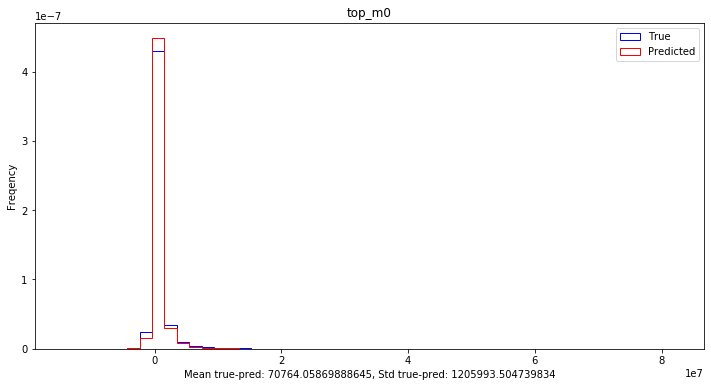

In [29]:
# top_m0= th_m**2-th_p**2 + tl_m**2-tl_p**2
plt.figure(figsize=(12,6))
observables.plot_hist(truths['top_m0'],preds['top_m0'])

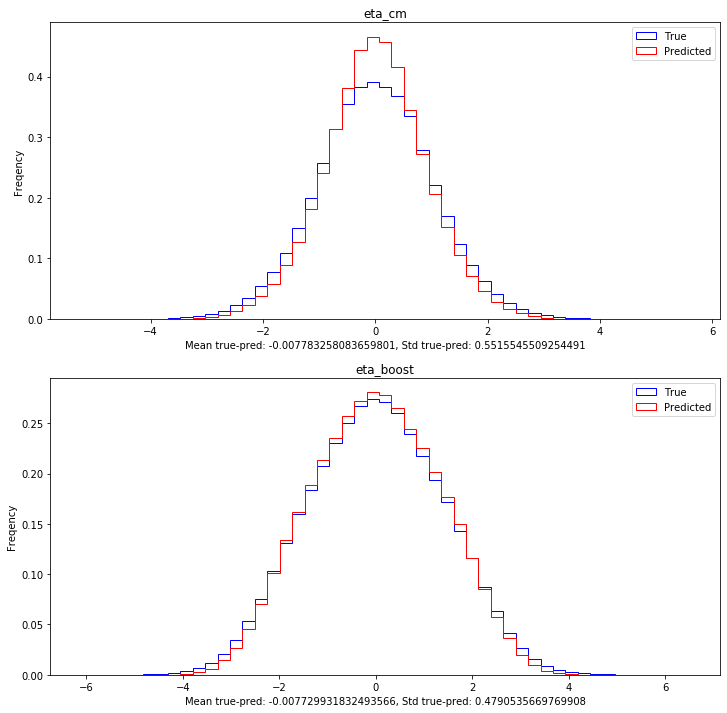

In [30]:
# eta_cm=0.5*(th_eta-tl_eta), eta_boost=0.5*(th_eta+tl_eta)
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['eta_cm'], preds['eta_cm'])
plt.subplot(212)
observables.plot_hist(truths['eta_boost'], preds['eta_boost'])


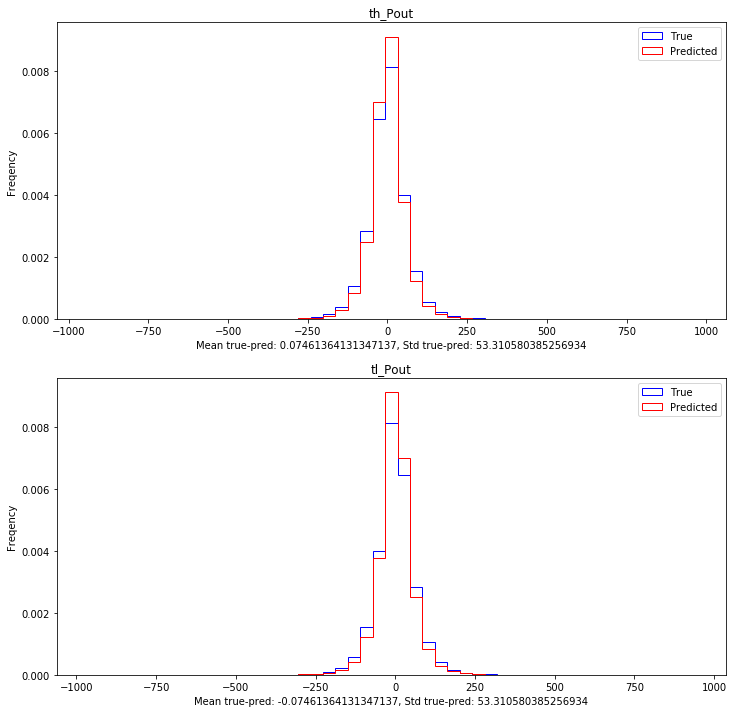

In [31]:
# th_Pout=dot(th_P, cross(tl_P,ez)/norm(tl_P,ez)), tl_Pout=dot(tl_P, cross(th_P,ez)/norm(th_P,ez))
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['th_Pout'], preds['th_Pout'])
plt.subplot(212)
observables.plot_hist(truths['tl_Pout'], preds['tl_Pout'])


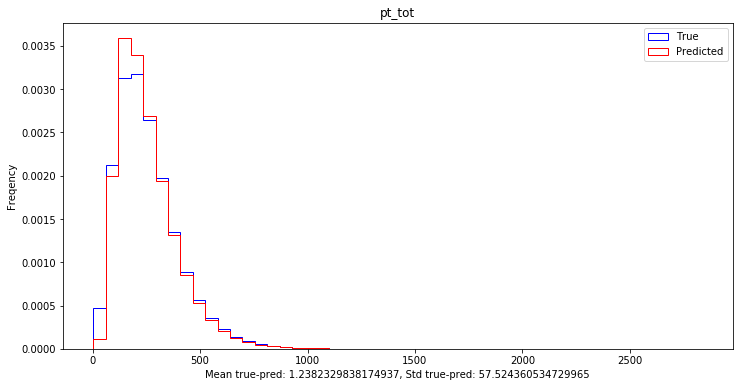

In [32]:
# pt_tot = th_pt+tl_pt
plt.figure(figsize=(12,6))
observables.plot_hist(truths['pt_tot'],preds['pt_tot'])